In [3]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
# ===== ENV =====
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

llm = ChatGroq(model="llama-3.3-70b-versatile")

result = llm.invoke("What is 2 + 2?")
result


e:\anaconda3\envs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='2 + 2 = 4.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 43, 'total_tokens': 52, 'completion_time': 0.012138842, 'completion_tokens_details': None, 'prompt_time': 0.0014559, 'prompt_tokens_details': None, 'queue_time': 0.054527039, 'total_time': 0.013594742}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c06d5113ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bf846-d344-7702-ba31-1dc6316dfd6f-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 43, 'output_tokens': 9, 'total_tokens': 52})

In [4]:
from langchain_core.tools import tool

@tool
def multiply(a:int, b:int)->int:
  """Multyply two numbers a and b
    Args:
        a (int): first number
        b (int): second number
  """
  return a * b
@tool
def add(a:int, b:int)->int:
  """Add two numbers a and b
    Args:
        a (int): first number
        b (int): second number
  """
  return a + b
@tool
def divide(a:int, b:int)->float:
  """Divide two numbers a and b
    Args:
        a (int): first number
        b (int): second number
  """
  return a / b

tools=[multiply, add, divide]

tools

[StructuredTool(name='multiply', description='Multyply two numbers a and b\n    Args:\n        a (int): first number\n        b (int): second number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000200D5B5A0C0>),
 StructuredTool(name='add', description='Add two numbers a and b\n    Args:\n        a (int): first number\n        b (int): second number', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x00000200D5B39EE0>),
 StructuredTool(name='divide', description='Divide two numbers a and b\n    Args:\n        a (int): first number\n        b (int): second number', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x00000200D6CF5580>)]

In [5]:
from langchain_core.messages import ToolMessage
from langgraph.graph import MessagesState

TOOLS = {
  "multiply":multiply,
  "add":add,
  "divide":divide
}

def tool_node(state: MessagesState):
    last_msg = state["messages"][-1]

    tool_call = last_msg.tool_calls[0]
    tool_name = tool_call["name"]
    tool_args = tool_call["args"]

    result = TOOLS[tool_name].invoke(tool_args)

    return {
        "messages": [
            ToolMessage(
                content=str(result),
                tool_call_id=tool_call["id"]
            )
        ]
    } 

def has_tool_call(state: MessagesState):
    last_msg = state["messages"][-1]
    return bool(getattr(last_msg, "tool_calls", None))


In [6]:
llm_with_tools =llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000200D5A91490>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000200D5BE8B10>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multyply two numbers a and b\n    Args:\n        a (int): first number\n        b (int): second number', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'Add two numbers a and b\n    Args:\n        a (int): fir

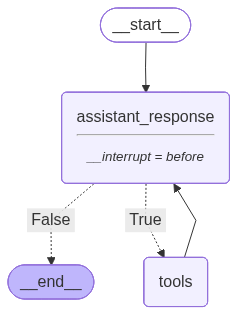

In [7]:
from IPython.display import display, Image

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage
# from langgraph.prebuilt import ToolNode



sys_msg = SystemMessage(content="You are a helpful assistant that can do basic math operations like addition, subtraction, multiplication and division.")

def assistant_response(state: MessagesState):
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


builder = StateGraph(MessagesState)

builder.add_node("assistant_response", assistant_response)
builder.add_node("tools",tool_node)
builder.add_edge(START, "assistant_response")
builder.add_conditional_edges(
  "assistant_response",
   has_tool_call,
   {
       True: "tools",
       False:"__end__"
   }
)

builder.add_edge("tools", "assistant_response")
memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant_response"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [ ]:
thread = {"configurable":{"thread_id":"123"}}
initial_input = {"messages":HumanMessage(content="12 nhân 3 bằng bao nhiêu?")}


In [9]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

12 nhân 3 bằng bao nhiêu?


In [10]:
state = graph.get_state(thread)
state.next

('assistant_response',)

In [11]:
state

StateSnapshot(values={'messages': [HumanMessage(content='12 nhân 3 bằng bao nhiêu?', additional_kwargs={}, response_metadata={}, id='f8e36ecc-fe07-496b-a898-91fad7f6c8e5')]}, next=('assistant_response',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0fa646-2e2b-66c0-8000-735b5afb2dbb'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-26T03:09:11.118406+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0fa646-2e2b-66bf-bfff-7166125fd7fa'}}, tasks=(PregelTask(id='76ad4348-e21c-0227-b240-9da79b6d2579', name='assistant_response', path=('__pregel_pull', 'assistant_response'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [12]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x00000200D6EEC1A0>

In [13]:
for event in graph.stream(None,thread,stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

12 nhân 3 bằng bao nhiêu?
================================== Ai Message ==================================
Tool Calls:
  multiply (myzpgtthv)
 Call ID: myzpgtthv
  Args:
    a: 12
    b: 3
================================= Tool Message =================================

36


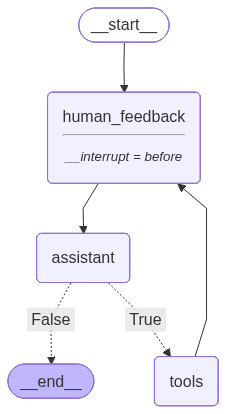

In [14]:
sys_msg = SystemMessage(content="You are a helpful assistant that can do basic math operations like addition, subtraction, multiplication and division. Always answer in Vietnamese.")

def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]} 

builder =StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools",tool_node)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
  "assistant",
   has_tool_call,
   {
       True: "tools",
       False:"__end__"
   }
)
builder.add_edge("tools", "human_feedback")
memory = MemorySaver()
graph  =builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
# Khôi phục hàm input() nếu bị ghi đè
import builtins
input = builtins.input

In [19]:

initial_input = {"messages":HumanMessage(content="12 nhân 3 bằng bao nhiêu?")}

thread = {"configurable":{"thread_id":"1234"}}

for event in graph.stream(initial_input,thread,stream_mode="values"):
  event['messages'][-1].pretty_print()

user_input  = input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

for event in graph.stream(None,thread,stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

12 nhân 3 bằng bao nhiêu?
================================ Human Message =================================

2 nhân 3 bằng bao nhiêu
================================== Ai Message ==================================
Tool Calls:
  multiply (7h6g90q02)
 Call ID: 7h6g90q02
  Args:
    a: 12
    b: 3
================================= Tool Message =================================

36
